In [10]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

first_results = Path().resolve()

janique_insert_result_here = "example.txt"

first_results = Path(first_results / f"DeepGlycanSite/DeepGlycanSite/User/{janique_insert_result_here}")


first_results.exists()

True

In [ ]:
def return_binding_probabilities(file_path: Path) -> tuple[list, int]:
    probabilities = []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            num = line.split("[")[1]
            num = num.split("]")[0]
            num = float(num)

            probabilities.append(num)
        
        num_residues = len(file.readlines())

    return probabilities, num_residues


In [ ]:
residue_number = []
first_probabilities = []

with open(first_results, "r") as file:
    lines = file.readlines()
    for line in lines:
        num = line.split("[")[1]
        num = num.split("]")[0]
        num = float(num)

        first_probabilities.append(num)
        residue_number.append(len(first_probabilities))
        

In [ ]:
second_probabilities = []

second_results = Path().resolve()
second_results = Path(second_results / "DeepGlycanSite/DeepGlycanSite/User/cbm3-gd2.txt")

print(gd2_results.exists())
count = 1

with open(gd2_results, "r") as file:
    lines = file.readlines()
    for line in lines:
        num = line.split("[")[1]
        num = num.split("]")[0]
        num = float(num)

        gd2_probabilities.append(num)
        residue_number.append(count)
        count += 1

True


In [97]:
data = pd.DataFrame(columns=["Residue Number", "Binding Probabilities"])

In [ ]:
first_ligand = "name_of_first_ligand"
second_ligand = "name_of_second_ligand"



data["Binding Probabilities"] = first_probabilities + gd2_probabilities
data["Residue Number"] = residue_number
data["Ligands"] = [f"{first_ligand}"] * 137 + [f"{second_ligand}"] * 137

significant_residues = [33, 61, 63, 66, 79, 80, 127]

data_filtered = data[data["Residue Number"].isin(significant_residues)]
data_filtered

,Residue Number,Binding Probabilities,Ligands
32,33,0.4756,GalNAc
60,61,0.5514,GalNAc
62,63,0.4988,GalNAc
65,66,0.5712,GalNAc
78,79,0.5003,GalNAc
79,80,0.5025,GalNAc
126,127,0.5245,GalNAc
169,33,0.5211,GD2
197,61,0.5599,GD2
199,63,0.5650,GD2


/var/folders/hf/cpph_csd2x15wb74htypnvbh0000gp/T/ipykernel_35067/1086378744.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  residue_graph.set_xticklabels(residue_labels)


[Text(0, 0, 'Y33'),
 Text(1, 0, 'V61'),
 Text(2, 0, 'P63'),
 Text(3, 0, 'E66'),
 Text(4, 0, 'E79'),
 Text(5, 0, 'D80'),
 Text(6, 0, 'K127')]

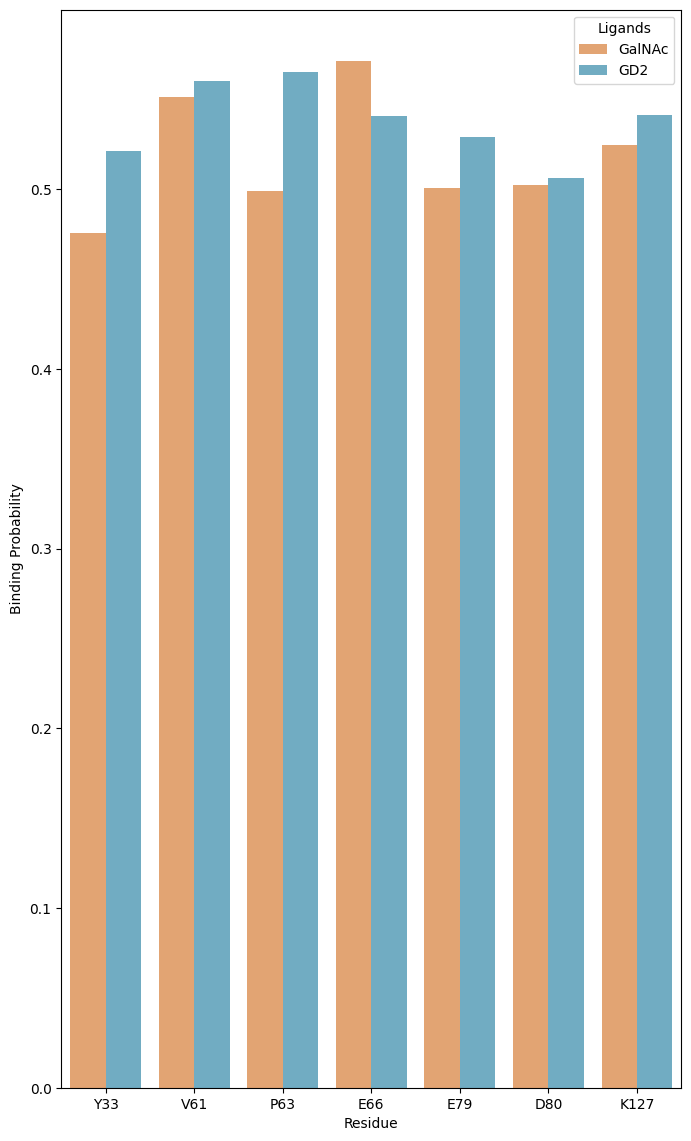

In [105]:
plt.figure(
    figsize=(8,14)
)

residue_labels = ["Y33", "V61", "P63", "E66", "E79", "D80", "K127"]



residue_graph = sns.barplot(
    data=data_filtered,
    y="Binding Probabilities",
    x="Residue Number",
    hue="Ligands",
    palette=["#f4a261", "#63b3cf"]
)

residue_graph.set_xlabel("Residue")
residue_graph.set_ylabel("Binding Probability")
residue_graph.set_xticklabels(residue_labels)
#residue_graph.set_ybound(0.1)